In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

### Data Pre-processing

In [141]:
train_locs = pd.read_csv('train_locs.csv')
train_pbp = pd.read_csv('train_pbp.csv')
test_locs = pd.read_csv('test_locs.csv')
test_pbp = pd.read_csv('test_pbp.csv')

In [142]:
train_locs

,id,court_x,court_y,annotation_code
0,2-2,72.807686,37.409669,d1
1,2-2,79.080643,31.477796,d2
2,2-2,69.956321,24.467300,d3
3,2-2,75.468933,13.861763,d4
4,2-2,84.973496,19.254422,d5
...,...,...,...,...
308045,5020-52,70.669644,7.270347,s
308046,5020-52,86.958520,4.382292,t1
308047,5020-52,58.962087,26.764930,t2
308048,5020-52,76.777949,20.427222,t3


#### Joining the datasets on the unique id

In [143]:
training_data = train_locs.copy()
testing_data = test_locs.copy()

In [144]:
training_data

,id,court_x,court_y,annotation_code
0,2-2,72.807686,37.409669,d1
1,2-2,79.080643,31.477796,d2
2,2-2,69.956321,24.467300,d3
3,2-2,75.468933,13.861763,d4
4,2-2,84.973496,19.254422,d5
...,...,...,...,...
308045,5020-52,70.669644,7.270347,s
308046,5020-52,86.958520,4.382292,t1
308047,5020-52,58.962087,26.764930,t2
308048,5020-52,76.777949,20.427222,t3


#### Creating new columns that represent whether each player is on offense or defense and whether or not they are the shooter
- these new columns capture the important details about each player as the number in the annotation code does not matter

In [145]:
training_data['offense'] = training_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
testing_data['offense'] = testing_data['annotation_code'].apply(lambda x: 0 if 'd' in x else 1)
training_data['shooter'] = training_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)
testing_data['shooter'] = testing_data['annotation_code'].apply(lambda x: 1 if 's' in x else 0)

In [146]:
training_data

,id,court_x,court_y,annotation_code,offense,shooter
0,2-2,72.807686,37.409669,d1,0,0
1,2-2,79.080643,31.477796,d2,0,0
2,2-2,69.956321,24.467300,d3,0,0
3,2-2,75.468933,13.861763,d4,0,0
4,2-2,84.973496,19.254422,d5,0,0
...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,1,1
308046,5020-52,86.958520,4.382292,t1,1,0
308047,5020-52,58.962087,26.764930,t2,1,0
308048,5020-52,76.777949,20.427222,t3,1,0


#### Feature Engineering Shot Distance from the basket
- A dangerous assumption is made here that the basket closest to the shot is the one being shot at, however given that most times a shot is taken from the other side of the court, time expires, there is likely very few such data points.
- Longer shots will likely lead to long rebounds which makes an offensive rebound more likely
- Shots very close to the basket may also be more likely to be offensive rebounded because the shooter could be in good position to rebound or they may have broken down the defense and drawn help away from a rim crasher

In [147]:
# Define the coordinates of the hoop
hoop_coordinates = np.array([[4, 25], [90, 25]])

# Calculate the distance of each shot from the basket
def calculate_shooter_distance_from_hoop(row):
    shot_coordinates = np.array([row['court_x'], row['court_y']])
    distance = np.linalg.norm(shot_coordinates - hoop_coordinates, axis=1)
    if distance[0] < distance[1]:
        hoop = 0
    else:
        hoop = 1
    return pd.Series([np.min(distance), hoop])

In [148]:
shooter_data_train = training_data.loc[training_data.annotation_code == 's']
shooter_data_test = testing_data.loc[testing_data.annotation_code == 's']

In [149]:
# Hoop at x = 4 is 0, x = 90 is 1
shooter_data_train[['distance_from_hoop', 'which_hoop']] = shooter_data_train.apply(calculate_shooter_distance_from_hoop, axis=1)
shooter_data_test[['distance_from_hoop', 'which_hoop']] = shooter_data_test.apply(calculate_shooter_distance_from_hoop, axis=1)

C:\Users\timse\AppData\Local\Temp\ipykernel_16216\2934421334.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\timse\AppData\Local\Temp\ipykernel_16216\2934421334.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\timse\AppData\Local\Temp\ipykernel_16216\2934421334.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [150]:
shooter_data_train

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop
5,2-2,69.994331,39.674616,s,1,1,24.810706,1.0
15,2-3,16.896578,13.154704,s,1,1,17.510933,0.0
25,2-4,87.963438,3.638889,s,1,1,21.457974,1.0
35,2-6,80.185287,22.850748,s,1,1,10.047281,1.0
45,2-8,70.659638,39.791936,s,1,1,24.348532,1.0
...,...,...,...,...,...,...,...,...
308005,5020-46,75.406582,43.315000,s,1,1,23.418093,1.0
308015,5020-47,34.976740,28.423749,s,1,1,31.165373,0.0
308025,5020-48,12.023261,24.935416,s,1,1,8.023521,0.0
308035,5020-49,63.025313,12.659930,s,1,1,29.663295,1.0


Let's investigate the relationship between shot distance and offensive rebounds

In [151]:
shot_distance = shooter_data_train.copy()

In [152]:
train_pbp['is_oreb']

0        0
1        0
2        0
3        1
4        0
        ..
30800    0
30801    1
30802    1
30803    1
30804    0
Name: is_oreb, Length: 30805, dtype: int64

In [153]:
shot_distance['oreb'] = train_pbp['is_oreb'].values

In [154]:
shot_distance

,id,court_x,court_y,annotation_code,offense,shooter,distance_from_hoop,which_hoop,oreb
5,2-2,69.994331,39.674616,s,1,1,24.810706,1.0,0
15,2-3,16.896578,13.154704,s,1,1,17.510933,0.0,0
25,2-4,87.963438,3.638889,s,1,1,21.457974,1.0,0
35,2-6,80.185287,22.850748,s,1,1,10.047281,1.0,1
45,2-8,70.659638,39.791936,s,1,1,24.348532,1.0,0
...,...,...,...,...,...,...,...,...,...
308005,5020-46,75.406582,43.315000,s,1,1,23.418093,1.0,0
308015,5020-47,34.976740,28.423749,s,1,1,31.165373,0.0,1
308025,5020-48,12.023261,24.935416,s,1,1,8.023521,0.0,1
308035,5020-49,63.025313,12.659930,s,1,1,29.663295,1.0,1


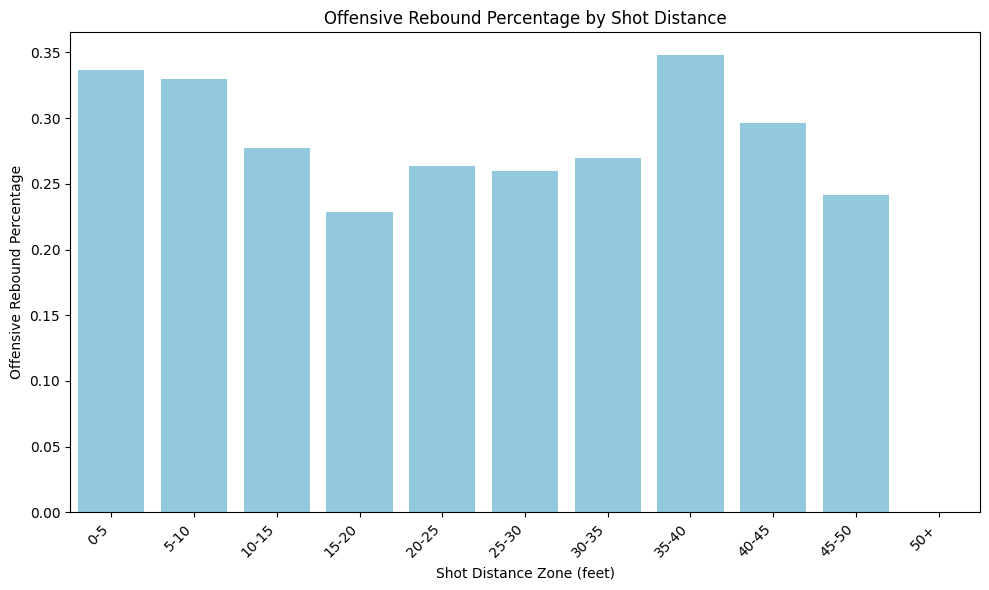

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Categorize each shot into the corresponding zones based on shot distance
shot_distance_bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, np.inf]
zone_labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50+']
shot_distance['shot_distance_zone'] = pd.cut(shot_distance['distance_from_hoop'], bins=shot_distance_bins, labels=zone_labels, right=False)

# Calculate the offensive rebound percentage for each shot distance zone
oreb_by_zone = shot_distance.groupby('shot_distance_zone')['oreb'].mean()

# Create the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=oreb_by_zone.index, y=oreb_by_zone.values, color='skyblue')
plt.title('Offensive Rebound Percentage by Shot Distance')
plt.xlabel('Shot Distance Zone (feet)')
plt.ylabel('Offensive Rebound Percentage')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Feature Engineering Average Distance of Defenders from the basket
- This feature will inform the spacing of the court at the time of the shot
- The further out the defense is, the harder it will be to box out and the more lanes there will be for offensive players to crash the boards
- There is even more risk here that a player will be on the other side of the court
    - The ground truth shooting hoop will be considered what hoop the shooter is closer to in order to maintain consistency despite the uncertainty

In [156]:
def calculate_def_distance_from_hoop(row):
    # Define the coordinates of the hoop
    hoop_coordinates = np.array([[4.0, 25.0], [90.0, 25.0]])  # Ensure the elements are floats
    def_coordinates = np.array([row['court_x'], row['court_y']])
    
    # Calculate the distance
    distance = np.linalg.norm(def_coordinates - hoop_coordinates[int(row['which_hoop'])])
    return distance

In [157]:
training_data = training_data.merge(shooter_data_train[['id', 'which_hoop']], left_on='id', right_on='id')
testing_data = testing_data.merge(shooter_data_test[['id', 'which_hoop']], left_on='id', right_on='id')

In [158]:
defenders_distance_train = training_data.loc[training_data.offense == 0]
defenders_distance_test = testing_data.loc[testing_data.offense == 0]

In [159]:
defenders_distance_train['def_distance'] = defenders_distance_train.apply(calculate_def_distance_from_hoop, axis=1)
defenders_distance_test['def_distance'] = defenders_distance_test.apply(calculate_def_distance_from_hoop, axis=1)

C:\Users\timse\AppData\Local\Temp\ipykernel_16216\4184772301.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\timse\AppData\Local\Temp\ipykernel_16216\4184772301.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [160]:
def_mean_distances_train = defenders_distance_train.groupby('id')['def_distance'].mean()
def_mean_distances_test = defenders_distance_test.groupby('id')['def_distance'].mean()

#### Feature Engineering Prior Offensive and Defensive Rebounding percentages

##### Rationale for Using Prior Rebounding Percentages and Imputing Mean for Small Samples

In basketball, the performance of a team in terms of offensive and defensive rebounds can be highly influenced by their historical performance. Teams with strong rebounding abilities are likely to maintain consistent performance in this aspect, which can be informative for predicting future rebounds. Additionally, since the dataset might contain limited samples for some teams, imputing the mean rebound percentages helps address data sparsity and reduce the impact of outliers for such cases.

The `calculate_rebound_percentages` function takes a DataFrame as input and calculates the offensive and defensive rebound percentages for each team based on their historical performance. To avoid data leakage, it only uses information available up to each data point when calculating these percentages. The function updates the DataFrame with the calculated percentages and imputes the mean values for teams with fewer than 10 samples to ensure more stable predictions.

The steps in the function are as follows:

1. Create dictionaries to store team's offensive and defensive rebound counts, total offensive and defensive rebounds, and sample counts.
2. Iterate through each row in the DataFrame and update the corresponding counts for the offense and defense teams.
3. Calculate the offensive and defensive rebound percentages based on the available samples for each team and update the DataFrame with these values.
4. For teams with fewer than 10 samples, impute the mean offensive and defensive rebound percentages.
5. Return the updated DataFrame with the rebound percentages.

By incorporating historical rebound percentages as features, the model can gain valuable insights into team performance, leading to potentially improved predictive performance. Additionally, imputing mean values for small samples helps stabilize the predictions for teams with limited data and reduces the impact of outliers in these cases.

In [7]:
oreb_mean = train_pbp['is_oreb'].mean()
mean_off_reb_pct_train = oreb_mean
mean_def_reb_pct_train = 1 - oreb_mean

In [8]:
# Calculate offensive and defensive rebound percentages for each team
def calculate_rebound_percentages(df):
    # Create empty dictionaries to store team's offensive and defensive rebound counts
    team_off_rebounds = {}
    team_def_rebounds = {}

    # Create empty dictionaries to store team's total offensive and defensive rebounds and sample counts
    team_total_off_rebounds = {}
    team_total_def_rebounds = {}
    team_off_sample_counts = {}
    team_def_sample_counts = {}

    # Iterate through each row in the dataframe
    for index, row in df.iterrows():
        offense_team = row['team']
        defense_team = row['opponent']
        is_oreb = row['is_oreb']

        # Initialize offense team's rebound counts if not already present in the dictionaries
        if offense_team not in team_off_rebounds:
            team_off_rebounds[offense_team] = 0
            team_total_off_rebounds[offense_team] = 0
            team_off_sample_counts[offense_team] = 0

        # Initialize defense team's rebound counts if not already present in the dictionaries
        if defense_team not in team_def_rebounds:
            team_def_rebounds[defense_team] = 0
            team_total_def_rebounds[defense_team] = 0
            team_def_sample_counts[defense_team] = 0

        # Check if it's an offensive or defensive rebound and update the respective counts
        if is_oreb == 1:
            team_off_rebounds[offense_team] += 1
        else:
            team_def_rebounds[defense_team] += 1

        # Update the total rebound counts and sample counts for the teams
        team_total_off_rebounds[offense_team] += team_off_rebounds[offense_team]
        team_total_def_rebounds[defense_team] += team_def_rebounds[defense_team]
        team_off_sample_counts[offense_team] += 1
        team_def_sample_counts[defense_team] += 1

        # Calculate the offensive and defensive rebound percentages based on available samples
        off_reb_pct = team_off_rebounds[offense_team] / team_off_sample_counts[offense_team]
        def_reb_pct = team_def_rebounds[defense_team] / team_def_sample_counts[defense_team]

        # Assign the calculated percentages to the new columns for the current row
        df.at[index, 'off_reb_pct'] = off_reb_pct
        df.at[index, 'def_reb_pct'] = def_reb_pct

        # For samples with fewer than 10 data points, impute the mean offensive and defensive rebound percentages
        if team_off_sample_counts[offense_team] < 10:
            df.at[index, 'off_reb_pct'] = mean_off_reb_pct_train
        if team_def_sample_counts[defense_team] < 10:
            df.at[index, 'def_reb_pct'] = mean_def_reb_pct_train

    return df

# Call the function to calculate rebound percentages for the given dataframe
train_pbp_with_rebounds = calculate_rebound_percentages(train_pbp)

# Print the updated dataframe with offensive and defensive rebound percentages
print(train_pbp_with_rebounds)


            id  is_oreb           team       opponent conference  \
0          2-2        0       Kentucky           Duke        SEC   
1          2-3        0           Duke       Kentucky        ACC   
2          2-4        0       Kentucky           Duke        SEC   
3          2-6        1       Kentucky           Duke        SEC   
4          2-8        0       Kentucky           Duke        SEC   
...        ...      ...            ...            ...        ...   
30800  5020-46        0  San Diego St.    Connecticut        MWC   
30801  5020-47        1    Connecticut  San Diego St.    BigEast   
30802  5020-48        1    Connecticut  San Diego St.    BigEast   
30803  5020-49        1  San Diego St.    Connecticut        MWC   
30804  5020-52        0  San Diego St.    Connecticut        MWC   

      opp_conference  off_reb_pct  def_reb_pct  
0                ACC     0.281935     0.718065  
1                SEC     0.281935     0.718065  
2                ACC     0.281935   

In [10]:
train_pbp_with_rebounds

,id,is_oreb,team,opponent,conference,opp_conference,off_reb_pct,def_reb_pct
0,2-2,0,Kentucky,Duke,SEC,ACC,0.281935,0.718065
1,2-3,0,Duke,Kentucky,ACC,SEC,0.281935,0.718065
2,2-4,0,Kentucky,Duke,SEC,ACC,0.281935,0.718065
3,2-6,1,Kentucky,Duke,SEC,ACC,0.281935,0.718065
4,2-8,0,Kentucky,Duke,SEC,ACC,0.281935,0.718065
...,...,...,...,...,...,...,...,...
30800,5020-46,0,San Diego St.,Connecticut,MWC,BigEast,0.299242,0.798587
30801,5020-47,1,Connecticut,San Diego St.,BigEast,MWC,0.346260,0.791837
30802,5020-48,1,Connecticut,San Diego St.,BigEast,MWC,0.348066,0.788618
30803,5020-49,1,San Diego St.,Connecticut,MWC,BigEast,0.301887,0.795775


#### Creating image like matrices
- Representing the player positions on the court
- This approach is suitable for preparing the data to be used in a CNN

In [13]:
def create_court_grid(court_width, court_height):
    """
    Create an empty court grid with higher resolution and multiple channels for each play.

    Parameters
    ----------
    court_width : int
        The width of the court grid in the desired higher resolution. For example, the width in inches or centimeters.

    court_height : int
        The height of the court grid in the desired higher resolution. For example, the height in inches or centimeters.

    Returns
    -------
    numpy.ndarray
        A 3D NumPy array representing the court grid with high resolution and three channels.
        The dimensions of the array are (court_height, court_width, 3),
        where the three channels represent shooter, offense, and defense.

    Examples
    --------
    >>> court_width_inches = 500
    >>> court_height_inches = 940
    >>> grid = create_court_grid(court_width_inches, court_height_inches)
    >>> print(grid.shape)
    (940, 500, 3)
    """
    return np.zeros((court_height, court_width, 3))



def place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height):
    """
    Place player positions on the court grid with higher resolution and channels for shooter, offense, and defense.

    Parameters
    ----------
    court_grid : numpy.ndarray
        A 3D NumPy array representing the court grid with higher resolution and three channels.
        The array has dimensions (court_height_inches, court_width_inches, 3), where the three channels
        represent shooter, offense, and defense.

    player_positions : numpy.ndarray
        A 2D NumPy array containing the X and Y coordinates of the player positions.

    shooter_index : int
        The index of the shooter in the player_positions array.

    offense_indices : list
        A list of indices representing the players on offense in the player_positions array.

    defense_indices : list
        A list of indices representing the players on defense in the player_positions array.

    coordinate_multiplier : float
        The multiplier to convert the player positions from feet to the desired higher resolution (e.g., inches).

    Returns
    -------
    None
        This function modifies the court_grid in place, updating the shooter, offense, and defense channels
        based on the player_positions and corresponding indices.
    """
    for i, (x, y) in enumerate(player_positions):
        x_dist = x * coordinate_multiplier
        y_dist = y * coordinate_multiplier
        if 0 <= x_dist < court_width and 0 <= y_dist < court_height:
            # finding the index of the shooter
            if i == np.argmax(shooter_index):
                court_grid[int(y_dist)][int(x_dist)][0] = 1  # Shooter channel
            # finding the indices of offensive players and comparing to the index
            if i in np.where(offense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][1] = 1  # Offense channel
            if i in np.where(defense_indices == 1)[0]:
                court_grid[int(y_dist)][int(x_dist)][2] = 1  # Defense channel
    return court_grid

In [16]:
# Define the dimensions of the court grid with high resolution
# Depending on runtime, using lower resolution images may be a better approach here, but let's start with inches

coordinate_multiplier = 1
court_width = 94 * coordinate_multiplier
court_height = 50 * coordinate_multiplier

# Derive parameters from the data table
player_positions_train = training_data[['court_x', 'court_y']].values
shooter_indices_train = training_data['shooter'].values
offense_indices_train = training_data['offense'].values
defense_indices_train = training_data['offense'].apply(lambda x: 0 if x == 1 else 1).values # Complement of 'offense' column gives 'defense' indices

In [15]:
# Create image-like training examples with higher resolution and multiple channels
X_train_images = []
# Reshaping organizes the positions into a list of list of coordinates, so there is one training example per play
for index, (player_positions, shooter_index, offense_indices, defense_indices) in enumerate(zip(player_positions_train.reshape(-1, 10, 2), shooter_indices_train.reshape(-1, 10), offense_indices_train.reshape(-1, 10), defense_indices_train.reshape(-1, 10))):
    court_grid = create_court_grid(court_width, court_height)
    place_player_positions(court_grid, player_positions, shooter_index, offense_indices, defense_indices, coordinate_multiplier, court_width, court_height)
    X_train_images.append(court_grid)

In [16]:
X_train_images = np.array(X_train_images)

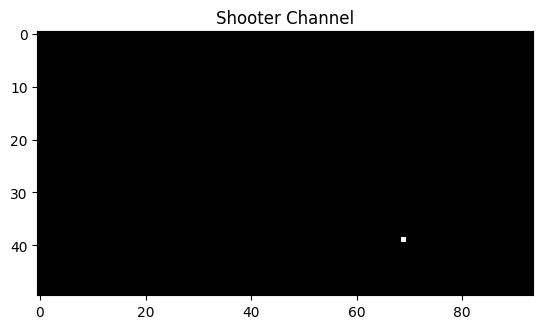

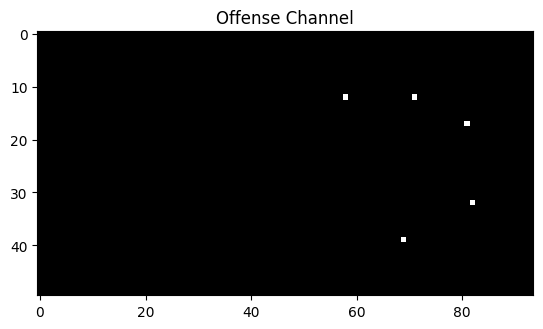

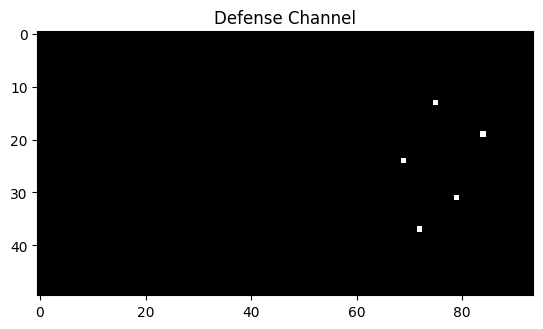

In [17]:
sample_index = 0

# Visualize the shooter channel
plt.imshow(X_train_images[sample_index, :, :, 0], cmap='gray')
plt.title("Shooter Channel")
plt.show()

# Visualize the offense channel
plt.imshow(X_train_images[sample_index, :, :, 1], cmap='gray')
plt.title("Offense Channel")
plt.show()

# Visualize the defense channel
plt.imshow(X_train_images[sample_index, :, :, 2], cmap='gray')
plt.title("Defense Channel")
plt.show()


In [161]:
y_train = train_pbp['is_oreb']

In [18]:

# Define the file path for saving the data
save_path = 'X_train_images.npz'

# Save the data to the file
np.savez_compressed(save_path, X_train_images=X_train_images)

In [10]:
# Load the data from the file
save_path = 'X_train_images.npz'
loaded_data = np.load(save_path)
X_train_images = loaded_data['X_train_images']

In [18]:
# # Split the data into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train_images, y_train, test_size=0.2, random_state=42)

In [16]:
# # Define the CNN model
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(court_height, court_width, 3)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(.01)))
# model.add(layers.Dense(1, activation='sigmoid'))  # Sigmoid activation for binary classification

# # Compile the model with log loss (binary cross-entropy)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# batch_size = 32
# epochs = 10

# history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# # Evaluate the model
# loss, accuracy = model.evaluate(X_val, y_val)
# print(f"Validation Loss (Log Loss): {loss:.4f}, Validation Accuracy: {accuracy:.4f}")


Epoch 1/10
771/771 [==============================] - 172s 221ms/step - loss: 0.6158 - accuracy: 0.7177 - val_loss: 0.6030 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 170s 220ms/step - loss: 0.5956 - accuracy: 0.7182 - val_loss: 0.5974 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 172s 223ms/step - loss: 0.5934 - accuracy: 0.7182 - val_loss: 0.5938 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 169s 220ms/step - loss: 0.5909 - accuracy: 0.7182 - val_loss: 0.5929 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 169s 219ms/step - loss: 0.5898 - accuracy: 0.7182 - val_loss: 0.5914 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 180s 233ms/step - loss: 0.5891 - accuracy: 0.7182 - val_loss: 0.5943 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 180s 234ms/step - loss: 0.5889 - accuracy: 0.7182 - val_loss: 0.5920 -

In [163]:
shooter_data_train['mean_def_dist'] = def_mean_distances_train.values
shooter_data_test['mean_def_dist'] = def_mean_distances_test.values

C:\Users\timse\AppData\Local\Temp\ipykernel_16216\3554656918.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [164]:
train_data = shooter_data_train[['mean_def_dist', 'distance_from_hoop']]
test_data = shooter_data_test[['mean_def_dist', 'distance_from_hoop']]

In [139]:
from sklearn import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

,mean_def_dist,distance_from_hoop
5,12.655892,24.810706
15,10.024629,17.510933
25,13.497611,21.457974
35,14.005532,10.047281
45,15.824908,24.348532
...,...,...
308005,11.202437,23.418093
308015,14.115630,31.165373
308025,11.693119,8.023521
308035,14.322072,29.663295


In [165]:
# Reshape the rebound percentage features to (num_samples, 1) to match the image data
X_train_data = train_data.values

# Split the data into training and validation sets
X_train_img, X_val_img, y_tr, y_val = train_test_split(X_train_images, y_train, test_size=0.2, random_state=42)
X_train_, X_val_, _, _ = train_test_split(X_train_data, y_train, test_size=0.2, random_state=42)

In [14]:
# Print the shapes of input data
print("Shape of X_train_img:", X_train_img.shape)
print("Shape of X_train_rebounds:", X_train_.shape)
print("Shape of X_val_img:", X_val_img.shape)
print("Shape of X_val_rebounds:", X_val_.shape)
print("Shape of y_tr:", y_tr.shape)
print("Shape of y_val:", y_val.shape)

# Define the multi-modal model
# ...

# Print the model summary for verification
model.summary()

Shape of X_train_img: (24644, 50, 94, 3)
Shape of X_train_rebounds: (607326736, 2)
Shape of X_val_img: (6161, 50, 94, 3)
Shape of X_val_rebounds: (37957921, 2)
Shape of y_tr: (24644,)
Shape of y_val: (6161,)


NameError: name 'model' is not defined

In [167]:
# Define the CNN model for image data
input_img = Input(shape=(court_height, court_width, 3))  # Assuming 3 channels for the image data
x = Conv2D(32, (3, 3), activation='relu')(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(.01))(x)
x = Dropout(0.5)(x)

# Define the input layer for rebound percentage features
input_rebounds = Input(shape=(2,))  # Assuming 1 feature for rebound percentages

# Concatenate the outputs from the two branches
combined = Concatenate()([x, input_rebounds])
output = Dense(1, activation='sigmoid')(combined)

# Create the multi-modal model
model = Model(inputs=[input_img, input_rebounds], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit([X_train_img, X_train_rebounds], y_tr, batch_size=batch_size, epochs=epochs, validation_data=([X_val_img, X_val_rebounds], y_val))

# Evaluate the model on the validation set
val_predictions = model.predict([X_val_img, X_val_rebounds])
val_loss = log_loss(y_val, val_predictions)
val_accuracy = np.mean((val_predictions > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


Epoch 1/10
771/771 [==============================] - 70s 89ms/step - loss: 0.6724 - accuracy: 0.7176 - val_loss: 0.6003 - val_accuracy: 0.7174
Epoch 2/10
771/771 [==============================] - 71s 92ms/step - loss: 0.5996 - accuracy: 0.7182 - val_loss: 0.5989 - val_accuracy: 0.7174
Epoch 3/10
771/771 [==============================] - 69s 90ms/step - loss: 0.5979 - accuracy: 0.7182 - val_loss: 0.5951 - val_accuracy: 0.7174
Epoch 4/10
771/771 [==============================] - 68s 89ms/step - loss: 0.5936 - accuracy: 0.7182 - val_loss: 0.5938 - val_accuracy: 0.7174
Epoch 5/10
771/771 [==============================] - 74s 96ms/step - loss: 0.5904 - accuracy: 0.7182 - val_loss: 0.5881 - val_accuracy: 0.7174
Epoch 6/10
771/771 [==============================] - 73s 94ms/step - loss: 0.5873 - accuracy: 0.7182 - val_loss: 0.5879 - val_accuracy: 0.7174
Epoch 7/10
771/771 [==============================] - 75s 98ms/step - loss: 0.5854 - accuracy: 0.7182 - val_loss: 0.5860 - val_accuracy:

C:\Users\timse\AppData\Local\Temp\ipykernel_16216\2900417551.py:34: DeprecationWarning:

elementwise comparison failed; this will raise an error in the future.



ValueError: Data must be 1-dimensional

In [26]:
val_predictions

array([[0.26378873],
       [0.19812655],
       [0.21622956],
       ...,
       [0.35289568],
       [0.25312468],
       [0.20602657]], dtype=float32)

In [168]:
val_loss = log_loss(y_val, val_predictions.flatten())
val_accuracy = np.mean((val_predictions.flatten() > 0.5) == y_val)

# Print the results
print(f"Validation Log Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

Validation Log Loss: 0.5820042970390139
Validation Accuracy: 0.7175783152085701


In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
train_pbp['team'].value_counts()

Duke                 1432
Kentucky              963
Alabama               758
Auburn                757
Arizona               750
                     ... 
Bradley                 9
Texas Southern          9
Belmont                 9
Southern Illinois       9
Utah Valley             6
Name: team, Length: 160, dtype: int64

Thoughts:
- tendencies to get back on defense may determine how often there is an offensive rebound - past offensive rebounding performance by team may be helpful
- spacing
- strength of the team / athleticisim of the players may be informed by conference

In [ ]:
training_data

,id,court_x,court_y,annotation_code,is_oreb,team,opponent,conference,opp_conference
0,2-2,72.807686,37.409669,d1,0,Kentucky,Duke,SEC,ACC
1,2-2,79.080643,31.477796,d2,0,Kentucky,Duke,SEC,ACC
2,2-2,69.956321,24.467300,d3,0,Kentucky,Duke,SEC,ACC
3,2-2,75.468933,13.861763,d4,0,Kentucky,Duke,SEC,ACC
4,2-2,84.973496,19.254422,d5,0,Kentucky,Duke,SEC,ACC
...,...,...,...,...,...,...,...,...,...
308045,5020-52,70.669644,7.270347,s,0,San Diego St.,Connecticut,MWC,BigEast
308046,5020-52,86.958520,4.382292,t1,0,San Diego St.,Connecticut,MWC,BigEast
308047,5020-52,58.962087,26.764930,t2,0,San Diego St.,Connecticut,MWC,BigEast
308048,5020-52,76.777949,20.427222,t3,0,San Diego St.,Connecticut,MWC,BigEast


In [ ]:
X_train = training_data[['court_x', 'court_y', 'annotation_code']]
X_test = testing_data[['court_x', 'court_y', 'annotation_code']]
y_train = training_data['is_oreb']
y_test = training_data['is_oreb']

In [ ]:
X_train.drop(columns='annotation_code', inplace=True)
X_test.drop(columns='annotation_code', inplace=True)

<ipython-input-21-4b650e9c37e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(columns='annotation_code', inplace=True)
<ipython-input-21-4b650e9c37e3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(columns='annotation_code', inplace=True)


There are imperfect maximums and minimums in the training set, so to ensure the actual player positions are not distorted, I will make a custom scaler instead of using minmax scaler

In [ ]:
X_train.max(), X_train.min()

(court_x    93.92656
 court_y    50.00000
 offense     1.00000
 shooter     1.00000
 dtype: float64,
 court_x    0.004518
 court_y    0.980564
 offense    0.000000
 shooter    0.000000
 dtype: float64)

In [ ]:
pd.read_csv('sample_sumbission.csv')

,id,pred
0,10-36,0.055351
1,264-34,0.101707
2,97-55,0.133729
3,299-28,0.494946
4,127-25,0.522130
5,188-58,0.782107
6,145-9,0.084935
7,72-5,0.186027
8,95-33,0.914862
9,286-69,0.662853


In [ ]:
y_train

0         0
1         0
2         0
3         0
4         0
         ..
308045    0
308046    0
308047    0
308048    0
308049    0
Name: is_oreb, Length: 308050, dtype: int64

In [ ]:
# Assuming you have the feature-engineered X_train and X_test DataFrames
x_max_val = 94  # Maximum value for x coordinate
x_min_val = 0   # Minimum value for x coordinate
y_max_val = 50  # Maximum value for y coordinate
y_min_val = 0   # Minimum value for y coordinate

# Separate features and labels in X_train and X_test
X_train_features = X_train.drop(columns=['offense', 'shooter'])  # Excluding 'offense' and 'shooter' columns
X_test_features = X_test.drop(columns=['offense', 'shooter'])    # Excluding 'offense' and 'shooter' columns
y_train_labels = X_train[['offense', 'shooter']]  # 'offense' and 'shooter' columns as labels for y_train
y_test_labels = X_test[['offense', 'shooter']]    # 'offense' and 'shooter' columns as labels for y_test

# Custom normalization function
def custom_normalize(data, max_val, min_val):
    return (data - min_val) / (max_val - min_val)

# Apply custom normalization to features
X_train_normalized = X_train_features.copy()
X_train_normalized['court_x'] = custom_normalize(X_train_features['court_x'], x_max_val, x_min_val)
X_train_normalized['court_y'] = custom_normalize(X_train_features['court_y'], y_max_val, y_min_val)

X_test_normalized = X_test_features.copy()
X_test_normalized['court_x'] = custom_normalize(X_test_features['court_x'], x_max_val, x_min_val)
X_test_normalized['court_y'] = custom_normalize(X_test_features['court_y'], y_max_val, y_min_val)

# Add the labels back to the preprocessed DataFrames
X_train_normalized[['offense', 'shooter']] = y_train_labels.reset_index(drop=True)
X_test_normalized[['offense', 'shooter']] = y_test_labels.reset_index(drop=True)

# Now, X_train_normalized contains the normalized data for X_train with labels,
# and X_test_normalized contains the normalized data for X_test with labels.
